# Progression
- used Prashant's algorithm to extract some epitheliums
- take a random point inside epithelium, start building squares around the point until any two corners are not touching epithelium
- shrink square dimensions into a rectangular patch until opposite corners are not either background or stroma
- sample 50 random points per tissue set to get average patch dimensions

### Notes
- only used "normal" tissues, only H&E since those are extracted well by Prashant
- 

In [2]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Importing Epithelium Extractions (Ran Prashant's Algo Separately)

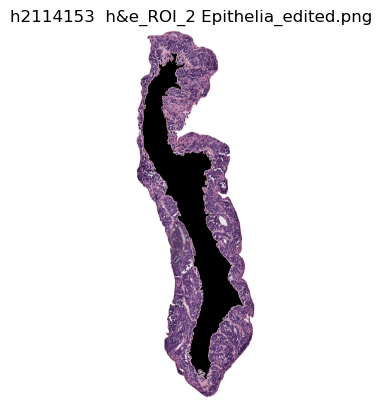

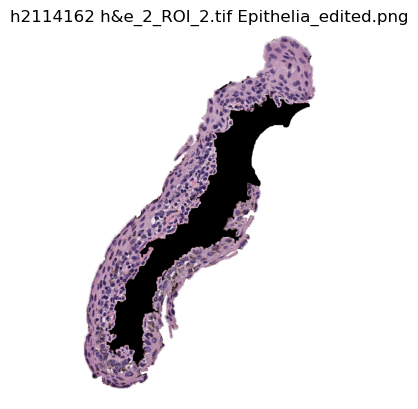

In [22]:
## import + display extractions

import os

folder_path = 'D:\\390scans\\background_white\\'

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.tif'):
        # Construct full file path
        file_path = os.path.join(folder_path, filename)
        
        # Load and display the image
        img = mpimg.imread(file_path)
        
        # Check if the image has an alpha channel and remove it if necessary
        if img.shape[2] == 4:
            img = img[:, :, :3]
        
        plt.imshow(img)
        plt.axis('off')  # Hide axes
        plt.title(filename)  # Show the filename as the title
        plt.show()


## Generate Patchs for n random points

Random points coordinates: [(1219, 1136), (1554, 757), (1609, 422), (491, 1434), (1907, 328)]


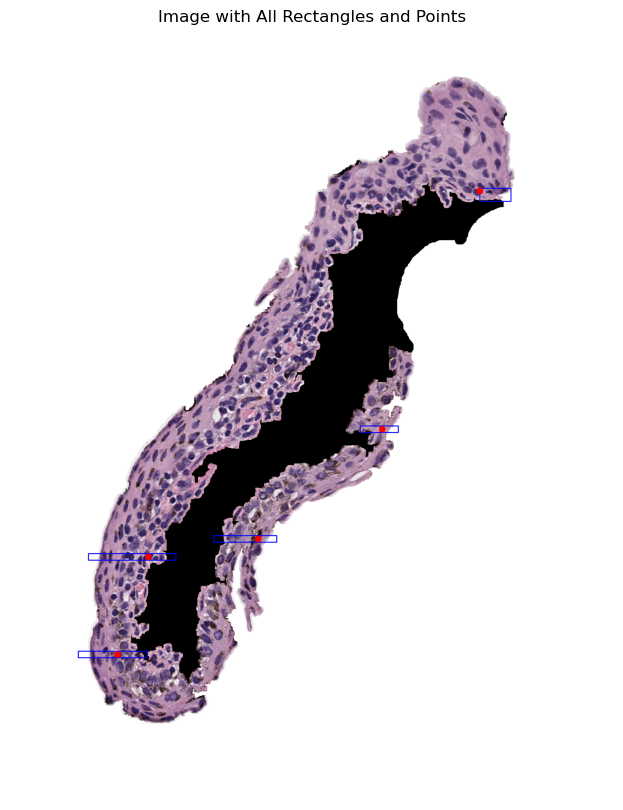

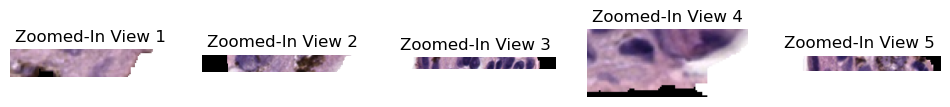

Rectangle 1 dimensions: Width = 116 pixels, Height = 20 pixels
Rectangle 2 dimensions: Width = 192 pixels, Height = 20 pixels
Rectangle 3 dimensions: Width = 267 pixels, Height = 20 pixels
Rectangle 4 dimensions: Width = 95 pixels, Height = 40 pixels
Rectangle 5 dimensions: Width = 211 pixels, Height = 20 pixels


In [18]:
import cv2
import numpy as np
import random

image_path = 'D:\\390scans\\background_white\\h2114162 h&e_2_ROI_2.tif Epithelia_edited.png' 
image = cv2.imread(image_path)

def contains_black_white_mask(region):
    contains_black = np.any(np.all(region == [0, 0, 0], axis=-1))
    contains_white = np.any(np.all(region == [255, 255, 255], axis=-1))
    contains_mask = np.any((region != [0, 0, 0]).all(axis=-1) & (region != [255, 255, 255]).all(axis=-1))
    return contains_black and contains_white and contains_mask

# Create a mask for non-black and non-white pixels
non_black_white_mask = cv2.inRange(image, np.array([1, 1, 1]), np.array([254, 254, 254]))

# Find the coordinates of all non-black, non-white pixels
coordinates = np.column_stack(np.where(non_black_white_mask > 0))

# Select 5 random points from these coordinates
random_points = [random.choice(coordinates) for _ in range(5)]
print(f"Random points coordinates: {[(p[0], p[1]) for p in random_points]}")

# Copy the original image to draw squares for each random point
image_with_rectangles = image.copy()
zoomed_in_regions = []
rect_dimensions = []

# Parameters for square size
initial_size = 40

# Process each random point
for random_point in random_points:
    center_x, center_y = int(random_point[1]), int(random_point[0])
    num_squares_drawn = 0

    while True:
        # Calculate the current square's size
        size = initial_size * (num_squares_drawn + 1)
        
        # Calculate the top-left and bottom-right coordinates of the square
        top = center_y - size
        bottom = center_y + size
        left = center_x - size
        right = center_x + size

        # Define regions at each corner of the square
        corner_checks = {
            "top_left": (top, left),
            "top_right": (top, right - initial_size),
            "bottom_left": (bottom - initial_size, left),
            "bottom_right": (bottom - initial_size, right - initial_size)
        }

        # Track how many corners are outside the mask
        corners_outside_count = 0

        # Check each corner and determine if it is outside the mask
        for corner_name, (corner_y, corner_x) in corner_checks.items():
            # Ensure the region is within the image bounds
            if corner_y < 0 or corner_x < 0 or corner_y + initial_size > image.shape[0] or corner_x + initial_size > image.shape[1]:
                corners_outside_count += 1
                continue

            # Extract the corner region in the mask at this corner
            corner_region = non_black_white_mask[corner_y:corner_y + initial_size, corner_x:corner_x + initial_size]
            
            # If all pixels in the corner region are black, mark this corner as outside the mask
            if not np.any(corner_region):
                corners_outside_count += 1

            # Stop checking if we already have two corners outside
            if corners_outside_count >= 2:
                break

        # Stop drawing squares if at least two corners are outside the mask
        if corners_outside_count >= 2:
            square_region = image[max(0, top):min(image.shape[0], bottom), max(0, left):min(image.shape[1], right)]
            contains_black = np.any(np.all(square_region == [0, 0, 0], axis=-1))
            contains_white = np.any(np.all(square_region == [255, 255, 255], axis=-1))

            if contains_black and contains_white:
                break

        # Increment the number of squares drawn
        num_squares_drawn += 1

    # Step 2: Shrink the top, bottom, left, and right edges independently
    can_shrink_top, can_shrink_bottom, can_shrink_left, can_shrink_right = True, True, True, True
    while (bottom - top) > 20:
        if can_shrink_top:
            top += 1
            if not contains_black_white_mask(image[top:bottom, left:right]):
                top -= 1
                can_shrink_top = False
        if can_shrink_bottom:
            bottom -= 1
            if not contains_black_white_mask(image[top:bottom, left:right]):
                bottom += 1
                can_shrink_bottom = False
        if not (top < center_y < bottom): break
        if not (can_shrink_top or can_shrink_bottom): break
    if not can_shrink_top: top = max(0, top - 20)
    if not can_shrink_bottom: bottom = min(image.shape[0], bottom + 20)

    while can_shrink_left or can_shrink_right:
        if can_shrink_left:
            left += 1
            if not contains_black_white_mask(image[top:bottom, left:right]):
                left -= 1
                can_shrink_left = False
        if can_shrink_right:
            right -= 1
            if not contains_black_white_mask(image[top:bottom, left:right]):
                right += 1
                can_shrink_right = False
        if not (left < center_x < right): break
    if not can_shrink_left: left = max(0, left - 30)
    if not can_shrink_right: right = min(image.shape[1], right + 30)

    # Draw the final rectangle for this point on the image copy
    cv2.rectangle(image_with_rectangles, (left, top), (right, bottom), (255, 0, 0), 2)
    cv2.circle(image_with_rectangles, (center_x, center_y), radius=10, color=(0, 0, 255), thickness=-1)

    # Crop and store the zoomed-in region
    zoomed_in_regions.append(image[top:bottom, left:right])

    # Store dimensions for each rectangle
    final_width = right - left
    final_height = bottom - top
    rect_dimensions.append((final_width, final_height))

# Display the original image with all rectangles
plt.figure(figsize=(10, 10))
plt.title("Image with All Rectangles and Points")
plt.imshow(cv2.cvtColor(image_with_rectangles, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Display zoomed-in regions
plt.figure(figsize=(12, 6))
for i, region in enumerate(zoomed_in_regions, 1):
    plt.subplot(1, 5, i)
    plt.title(f"Zoomed-In View {i}")
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
    plt.axis("off")
plt.show()

# Print dimensions of each final rectangle
for i, (width, height) in enumerate(rect_dimensions, 1):
    print(f"Rectangle {i} dimensions: Width = {width} pixels, Height = {height} pixels")


# automated to input entire folder of images

Processing h2114153  h&e_ROI_2 Epithelia_edited.png - Random points coordinates: [(4945, 1951), (2724, 1615), (524, 665), (987, 1279), (949, 1064)]


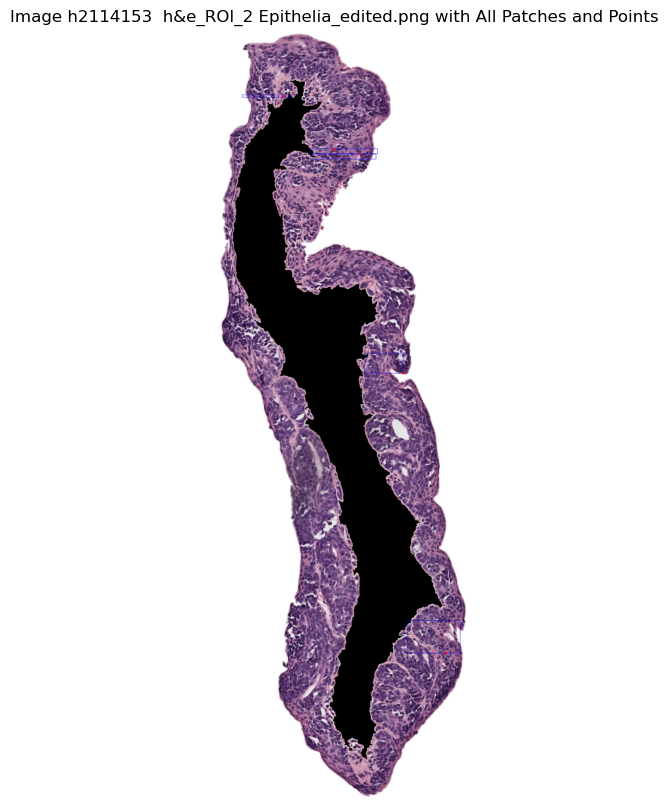

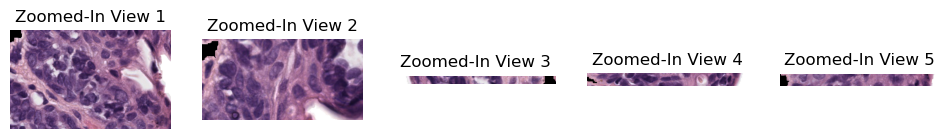

h2114153  h&e_ROI_2 Epithelia_edited.png - Patch 1 dimensions: Width = 419 pixels, Height = 258 pixels
h2114153  h&e_ROI_2 Epithelia_edited.png - Patch 2 dimensions: Width = 307 pixels, Height = 155 pixels
h2114153  h&e_ROI_2 Epithelia_edited.png - Patch 3 dimensions: Width = 392 pixels, Height = 20 pixels
h2114153  h&e_ROI_2 Epithelia_edited.png - Patch 4 dimensions: Width = 495 pixels, Height = 40 pixels
h2114153  h&e_ROI_2 Epithelia_edited.png - Patch 5 dimensions: Width = 534 pixels, Height = 40 pixels
Processing h2114162 h&e_2_ROI_2.tif Epithelia_edited.png - Random points coordinates: [(1264, 593), (1845, 329), (510, 1323), (221, 1249), (870, 914)]


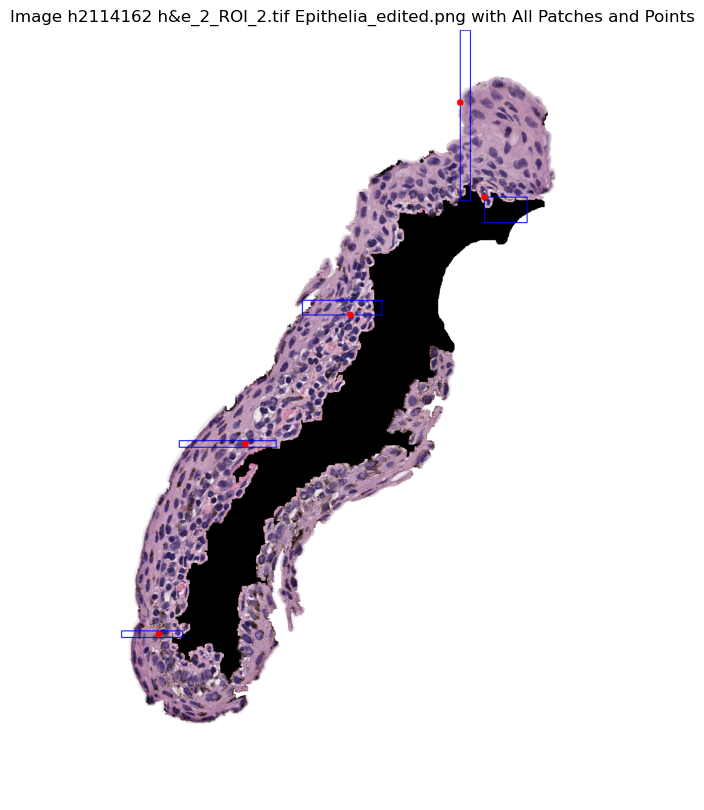

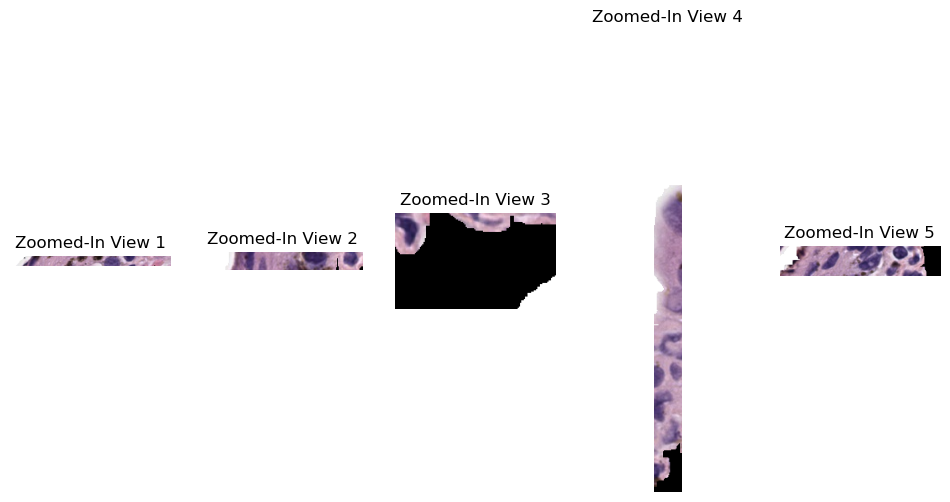

h2114162 h&e_2_ROI_2.tif Epithelia_edited.png - Patch 1 dimensions: Width = 296 pixels, Height = 20 pixels
h2114162 h&e_2_ROI_2.tif Epithelia_edited.png - Patch 2 dimensions: Width = 186 pixels, Height = 20 pixels
h2114162 h&e_2_ROI_2.tif Epithelia_edited.png - Patch 3 dimensions: Width = 130 pixels, Height = 78 pixels
h2114162 h&e_2_ROI_2.tif Epithelia_edited.png - Patch 4 dimensions: Width = 31 pixels, Height = 521 pixels
h2114162 h&e_2_ROI_2.tif Epithelia_edited.png - Patch 5 dimensions: Width = 243 pixels, Height = 45 pixels


In [25]:
import cv2
import numpy as np
import random
import os
from matplotlib import pyplot as plt

# Set the folder path containing the images
folder_path = 'D:\\390scans\\background_white' # update to your own folder
output_folder = 'D:\\390scans\\patches' # Specify an output folder for saving results

# Ensure output folder exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Parameters for square size
initial_size = 40

# Function to check if a region contains black, white, and mask pixels
def contains_black_white_mask(region):
    contains_black = np.any(np.all(region == [0, 0, 0], axis=-1))
    contains_white = np.any(np.all(region == [255, 255, 255], axis=-1))
    contains_mask = np.any((region != [0, 0, 0]).all(axis=-1) & (region != [255, 255, 255]).all(axis=-1))
    return contains_black and contains_white and contains_mask

# Process each image in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".png") or filename.endswith(".jpg") or filename.endswith(".tif"):  # Add other extensions if needed
        # Load the image
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        
        # Create a mask for non-black and non-white pixels
        non_black_white_mask = cv2.inRange(image, np.array([1, 1, 1]), np.array([254, 254, 254]))

        # Find the coordinates of all non-black, non-white pixels
        coordinates = np.column_stack(np.where(non_black_white_mask > 0))

        # Select 5 random points from these coordinates
        random_points = [random.choice(coordinates) for _ in range(5)]
        print(f"Processing {filename} - Random points coordinates: {[(p[0], p[1]) for p in random_points]}")

        # Copy the original image to draw squares for each random point
        image_with_rectangles = image.copy()
        zoomed_in_regions = []
        rect_dimensions = []

        # Process each random point
        for random_point in random_points:
            center_x, center_y = int(random_point[1]), int(random_point[0])
            num_squares_drawn = 0

            while True:
                # Calculate the current square's size
                size = initial_size * (num_squares_drawn + 1)
                
                # Calculate the top-left and bottom-right coordinates of the square
                top = center_y - size
                bottom = center_y + size
                left = center_x - size
                right = center_x + size

                # Define regions at each corner of the square
                corner_checks = {
                    "top_left": (top, left),
                    "top_right": (top, right - initial_size),
                    "bottom_left": (bottom - initial_size, left),
                    "bottom_right": (bottom - initial_size, right - initial_size)
                }

                # Track how many corners are outside the mask
                corners_outside_count = 0

                # Check each corner and determine if it is outside the mask
                for corner_name, (corner_y, corner_x) in corner_checks.items():
                    # Ensure the region is within the image bounds
                    if corner_y < 0 or corner_x < 0 or corner_y + initial_size > image.shape[0] or corner_x + initial_size > image.shape[1]:
                        corners_outside_count += 1
                        continue

                    # Extract the corner region in the mask at this corner
                    corner_region = non_black_white_mask[corner_y:corner_y + initial_size, corner_x:corner_x + initial_size]
                    
                    # If all pixels in the corner region are black, mark this corner as outside the mask
                    if not np.any(corner_region):
                        corners_outside_count += 1

                    # Stop checking if we already have two corners outside
                    if corners_outside_count >= 2:
                        break

                # Stop drawing squares if at least two corners are outside the mask
                if corners_outside_count >= 2:
                    square_region = image[max(0, top):min(image.shape[0], bottom), max(0, left):min(image.shape[1], right)]
                    contains_black = np.any(np.all(square_region == [0, 0, 0], axis=-1))
                    contains_white = np.any(np.all(square_region == [255, 255, 255], axis=-1))

                    if contains_black and contains_white:
                        break

                # Increment the number of squares drawn
                num_squares_drawn += 1

            # Step 2: Shrink the top, bottom, left, and right edges independently
            can_shrink_top, can_shrink_bottom, can_shrink_left, can_shrink_right = True, True, True, True
            while (bottom - top) > 20:
                if can_shrink_top:
                    top += 1
                    if not contains_black_white_mask(image[top:bottom, left:right]):
                        top -= 1
                        can_shrink_top = False
                if can_shrink_bottom:
                    bottom -= 1
                    if not contains_black_white_mask(image[top:bottom, left:right]):
                        bottom += 1
                        can_shrink_bottom = False
                if not (top < center_y < bottom): break
                if not (can_shrink_top or can_shrink_bottom): break
            if not can_shrink_top: top = max(0, top - 20)
            if not can_shrink_bottom: bottom = min(image.shape[0], bottom + 20)

            while can_shrink_left or can_shrink_right:
                if can_shrink_left:
                    left += 1
                    if not contains_black_white_mask(image[top:bottom, left:right]):
                        left -= 1
                        can_shrink_left = False
                if can_shrink_right:
                    right -= 1
                    if not contains_black_white_mask(image[top:bottom, left:right]):
                        right += 1
                        can_shrink_right = False
                if not (left < center_x < right): break
            if not can_shrink_left: left = max(0, left - 30)
            if not can_shrink_right: right = min(image.shape[1], right + 30)

            # Draw the final rectangle for this point on the image copy
            cv2.rectangle(image_with_rectangles, (left, top), (right, bottom), (255, 0, 0), 2)
            cv2.circle(image_with_rectangles, (center_x, center_y), radius=10, color=(0, 0, 255), thickness=-1)

            # Crop and store the zoomed-in region
            zoomed_in_regions.append(image[top:bottom, left:right])

            # Store dimensions for each patch
            final_width = right - left
            final_height = bottom - top
            rect_dimensions.append((final_width, final_height))

        # Save the original image with all patches
        output_image_path = os.path.join(output_folder, f"patches_{filename}")
        cv2.imwrite(output_image_path, image_with_rectangles)

        # Display the original image with all patches
        plt.figure(figsize=(10, 10))
        plt.title(f"Image {filename} with All Patches and Points")
        plt.imshow(cv2.cvtColor(image_with_rectangles, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

        # Display zoomed-in regions
        plt.figure(figsize=(12, 6))
        for i, region in enumerate(zoomed_in_regions, 1):
            plt.subplot(1, 5, i)
            plt.title(f"Zoomed-In View {i}")
            plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
            plt.axis("off")
        plt.show()

        # Print dimensions of each final patch
        for i, (width, height) in enumerate(rect_dimensions, 1):
            print(f"{filename} - Patch {i} dimensions: Width = {width} pixels, Height = {height} pixels")

        # Clear zoomed regions and dimensions for the next image
        zoomed_in_regions.clear()
        rect_dimensions.clear()


# Next Steps
- Find average/variance of dimensions across scans for 10 patients
- Use distance ratio of random point to background/stroma to discard bad starting points
- Generate more samples per patient
- sometimes vertical patches are still not ideally sized
- stroma sometimes seen twice in final patch